# Identifying Regions of Interest with Segmentation
The Allen Institute uses [**Suite2P**](http://www.suite2p.org/) for processing 2-Photon Calcium Imaging Data. Specifically, **Suite2P** takes a 2P movie, and outputs information about the putative segmented *Regions of Interest* (ROIs) {cite}`Pachitariu2017`. The most pertinent information outputted are the locations/shapes of the ROIs within the 2P Movie's field-of-view, as well as the fluorescence of each ROI at every frame of the movie. This notebook serves as a simple demonstration of how to input a 2P Movie into Suite2P and produce cell segmentation and fluorescence output.


### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import h5py
import os
import suite2p

import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from dandi import download
from dandi import dandiapi

%matplotlib inline

### Getting The Classifier
Suite2p uses a linear regression classifier in order to identify ROIs. If a classifier is not provided, suite2p uses a default classifier. However, the segmentation output is much better if a classifier trained on manually annotated data is used. The databook includes a classifier file that was trained using the [Suite2p GUI](https://suite2p.readthedocs.io/en/latest/gui.html). The Suite2p GUI is a very powerful platform that exceeds the limits of what can be shown in a Jupyter notebook. The cell below ensures that the classifier we need is present in the right location. In case this notebooks is being run outside the OpenScope Databook, it must be downloaded.

To make your own classifier with the Suite2p GUI, you must first `load` an `iscell.npy` file. This is one of the output files of Suite2p shown toward the end of this notebook. Then you can view both cell and non-cell ROIs by pressing the `both` button in the top of the GUI. From there, right-clicking ROIs will move them from either the cell or non-cell classification. After the manual classification is done, the classified data can be saved by pressing `add current data to classifier` in the bottom left.  

In [3]:
classifier_path = "../../data/suite2p_classifier.npy"
if not os.path.exists(classifier_path):
    url = "https://github.com/AllenInstitute/openscope_databook/blob/e5292764ac3edb0e798196df60dd5bf24732ad78/data/suite2p_classifier.npy"
    urllib.request.urlretrieve(url, "./suite2p_classifier.npy")
    classifier_path = "./suite2p_classifier.npy"

### Downloading Ophys NWB Files
Here you can download several files for a subject that you can run nway matching on. The pipeline can take in any number of input *sessions*, however, the input ophys data should be from the same imaging plane of the same subject. To specify your own file to use, set `dandiset_id` to be the dandiset id of the files you're interested in. Also set `input_dandi_filepaths` to be a list of the filepaths on dandi of each file you're interested in providing to **Nway Matching**. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key.

In [4]:
dandiset_id = "000037"
dandi_filepath = "sub-408021/sub-408021_ses-758519303_obj-raw_behavior+image+ophys.nwb"
download_loc = "."
dandi_api_key = None

In [5]:
client = dandiapi.DandiAPIClient(token=dandi_api_key)
dandiset = client.get_dandiset(dandiset_id)

file = dandiset.get_asset_by_path(dandi_filepath)
file_url = file.download_url

filename = dandi_filepath.split("/")[-1]
nwb_filepath = f"{download_loc}/{filename}"

h5_filepath = nwb_filepath.replace("nwb","h5")
if os.path.exists(nwb_filepath) or os.path.exists(h5_filepath):
    print("File already exists")
else:
    download.download(file_url, output_dir=download_loc)
    print(f"Downloaded file to {nwb_filepath}")
    os.rename(nwb_filepath, h5_filepath)

PATH                                                      SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-408021_ses-758519303_obj-raw_behavior+image+ophys.nwb 46.1 GB 46.1 GB          100%    -     done                   
Summary:                                                  46.1 GB 46.1 GB                        1 done                 
                                                                  100.00%                                               
Downloaded file to ./sub-408021_ses-758519303_obj-raw_behavior+image+ophys.nwb


### Preparing Suite2P Input
Typically, the 2P movie would not come prepared within an NWB file, but would be in some other form. Suite2P is capable of taking input in many forms, enumerated [here](https://suite2p.readthedocs.io/en/latest/inputs.html). Suite2P is capable of taking input in the form of h5py files. Since NWB files are a subset of h5py, we can convert it just by renaming the file and opening it with `h5py.file` This will have to be undone later in order to protect the validity of the file for PyNWB. The main setting to tweak the output of the segmentation is `threshold_scaling`. Lowering the threshold scaling makes the segmentation algorithm more sensitive, and will result in more segmented regions in the output. Since the classifier we provide is reasonably trained, it is sufficient to filter out a lot of the resultant messiness.

In [6]:
nwb = h5py.File(h5_filepath)

In [7]:
results_folder = "./results/"
scratch_folder = "./results/"
input_movie_path = "./movie"
threshold_scaling = 0.75
# sampling_rate = nwb["acquisition/raw_suite2p_motion_corrected/imaging_plane/imaging_rate"][()]
sampling_rate = nwb["processing"]["ophys"]["ImageSegmentation"]["PlaneSegmentation"]["imaging_plane"]["imaging_rate"][()]
print("Sampling Rate:", sampling_rate)

Sampling Rate: 30.0


### Running Suite2P
From there, input settings can be specified for Suite2P via the `ops` object. The available settings and their meanings are described [here](https://suite2p.readthedocs.io/en/latest/settings.html) The most pertinent settings are `results_folder`, `input_movie_path`, `data_path`, and `sampling_rate`. Here, the sampling rate is also retrieved from the NWB file, but should probably be known information for your movies.

In [8]:
ops = suite2p.default_ops()
ops['threshold_scaling'] = threshold_scaling
ops['fs'] = float(sampling_rate) # sampling rate of recording, determines binning for cell detection
ops['tau'] = 0.7 # timescale of gcamp to use for deconvolution
ops['do_registration'] = 0 # data was already registered
ops['save_folder'] = results_folder
ops['fast_disk'] = scratch_folder
ops["h5py"] = ["./"]
ops["h5py_key"] = "acquisition/motion_corrected_stack/data"
ops["classifier_path"] = classifier_path

output_ops = suite2p.run_s2p(ops=ops)

{}
h5
** Found 1 h5 files - converting to binary **
NOTE: using a list of h5 files:
['.\\sub-408021_ses-758519303_obj-raw_behavior+image+ophys.h5']
time 846.75 sec. Wrote 126741 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, ops['do_registration']=0
binary path: ./results/suite2p\plane0\data.bin
NOTE: applying classifier ../../data/suite2p_classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 25
Binned movie of size [5069,512,512] created in 182.66 sec.
NOTE: estimated spatial scale ~12 pixels, time epochs 4.22, threshold 31.68 
0 ROIs, score=639.61
1000 ROIs, score=36.82
Detected 1203 ROIs, 6122.50 sec
After removing overlaps, 1094 ROIs remain
----------- Total 6313.39 sec.
----------- EXTRACTION
Masks created, 5.00 sec.
Extracted fluorescence from 1094 ROIs in 126741 frames, 564.10 sec.
----------- Total 574.48 sec.
----------- CLASSIFICATION
['compact', 'npix_norm', 'skew']
----------- SPIKE DE

### Suite2P Output
Descriptions of the output of Suite2P can be found [here](https://suite2p.readthedocs.io/en/latest/outputs.html). Below, it is shown how to access each output file. Three files, `F.npy`, `Fneu.npy`, and `spks.npy` are 2D arrays containing various forms of the trace data that have shape # ROIs * # Frames. The settings and intermediate values are stored as a dictionary in `ops.npy`. `iscell.py` stores a table which, for each ROI, contains 1/0 if an ROI is a cell, and the certainty value of the classifier. 
Most importantly, the main statistics of each ROI are included in `stat.npy`. This is processed and shown as a dataframe below. Because the ROI location is stored as `xpix`, and `ypix`, which are arrays of coordinates, the code below produces an *ROI submask* for each ROI. The ROI submasks are more convenient for some purposes.

#### Traces

In [9]:
fluorescence = np.load("./results/plane0/F.npy")
neuropil = np.load("./results/plane0/Fneu.npy")
spikes = np.load("./results/plane0/spks.npy")

print(fluorescence.shape)
print(neuropil.shape)
print(spikes.shape)

(1094, 126741)
(1094, 126741)
(1094, 126741)


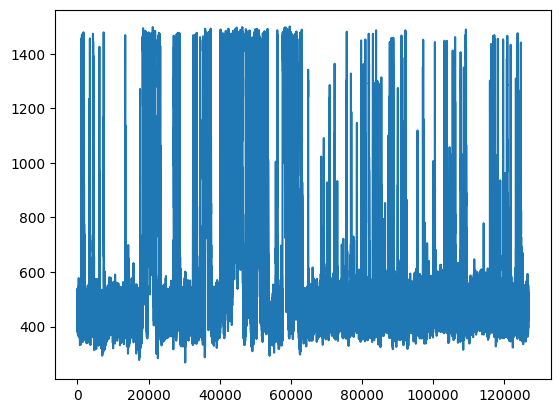

In [10]:
plt.plot(fluorescence[0])

#### Options and Intermediate Outputs

In [11]:
ops = np.load("./results/plane0/ops.npy", allow_pickle=True).item()
ops.keys()

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp_reg', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'sparse_mode', 'spatial_scale', 'connected', 'nbinned', 'max_iterations', 'threshold_scaling', 'max_overlap', 'high_pass'

#### Is-Cell Array

In [12]:
is_cell = np.load("./results/plane0/iscell.npy")
print(is_cell[:10])

[[1.         0.98007788]
 [1.         0.96206773]
 [1.         0.96443683]
 [1.         0.95716509]
 [1.         0.91303547]
 [1.         0.93703132]
 [1.         0.65620406]
 [1.         0.95688926]
 [1.         0.84348859]
 [1.         0.97860518]]


#### ROI Statistics

In [13]:
roi_stats = np.load("./results/plane0/stat.npy", allow_pickle=True)

In [14]:
stats_dict = {stat : [roi[stat] for roi in roi_stats] for stat in roi_stats[0].keys()}

In [15]:
def convert_pix_to_mask(xpix, ypix):
    x_loc = min(xpix)
    y_loc = min(ypix)
    rel_xpix = xpix - x_loc
    rel_ypix = ypix - y_loc
    width = max(xpix) - x_loc + 1
    height = max(ypix) - y_loc + 1
    
    mask = np.zeros((height, width))
    for y,x in zip(rel_ypix, rel_xpix):
        mask[y,x] = 1
    return mask

In [16]:
masks_col = []
for xpix, ypix in zip(stats_dict["xpix"], stats_dict["ypix"]):
    roi_mask = convert_pix_to_mask(xpix, ypix)
    masks_col.append(roi_mask)

# unionize dicts to ensure masks column goes first
stats_dict = {"mask": masks_col} | stats_dict

In [17]:
stats_df = pd.DataFrame(data=stats_dict)
print(stats_df.columns)
stats_df

Index(['mask', 'ypix', 'xpix', 'lam', 'med', 'footprint', 'mrs', 'mrs0',
       'compact', 'solidity', 'npix', 'npix_soma', 'soma_crop', 'overlap',
       'radius', 'aspect_ratio', 'npix_norm_no_crop', 'npix_norm', 'skew',
       'std', 'neuropil_mask'],
      dtype='object')


,mask,ypix,xpix,lam,med,footprint,mrs,mrs0,compact,solidity,...,npix_soma,soma_crop,overlap,radius,aspect_ratio,npix_norm_no_crop,npix_norm,skew,std,neuropil_mask
0,"[[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[459, 459, 459, 459, 459, 459, 459, 459, 459, ...","[482, 483, 484, 485, 486, 487, 488, 489, 490, ...","[3.3838997, 4.679903, 5.770184, 6.5203757, 6.8...","[465, 485]",2.0,1.060907,4.985990,1.005771,1.113924,...,176,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",7.582405,1.066600,0.859586,1.185265,1.952527,293.534790,"[231897, 231901, 231902, 231903, 231904, 23190..."
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[202, 203, 203, 203, 204, 204, 204, 204, 204, ...","[503, 502, 503, 504, 496, 497, 500, 501, 502, ...","[0.38524994, 0.56503004, 0.6567471, 0.36544192...","[221, 485]",2.0,1.229164,5.788569,1.003717,1.104895,...,237,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",8.045478,1.006510,1.355842,1.596067,2.071119,278.690002,"[100310, 100311, 100317, 100321, 100326, 10032..."
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[132, 133, 133, 133, 133, 133, 133, 134, 134, ...","[471, 468, 469, 470, 471, 472, 474, 466, 467, ...","[0.3694129, 0.4881493, 0.67727923, 0.8148415, ...","[141, 473]",2.0,1.311045,6.148370,1.007930,1.059524,...,267,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",8.580817,1.081453,1.462183,1.798101,2.730736,167.619888,"[61889, 61890, 61891, 61892, 61893, 61894, 618..."
3,"[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[231, 231, 231, 231, 231, 231, 231, 231, 232, ...","[48, 49, 50, 51, 52, 53, 54, 55, 48, 49, 50, 5...","[0.48071843, 0.48384356, 0.4858273, 0.58512807...","[241, 53]",2.0,1.237616,5.835270,1.002531,1.105505,...,241,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",8.013458,1.065926,1.307103,1.623005,1.192739,378.526947,"[114725, 114726, 114727, 114728, 114729, 11473..."
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[292, 293, 293, 294, 294, 294, 294, 295, 295, ...","[467, 467, 468, 467, 468, 469, 470, 467, 468, ...","[0.21621269, 0.39429575, 0.35337162, 0.4146063...","[349, 489]",2.0,1.214663,5.728179,1.002333,1.102138,...,232,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",7.476986,1.026523,3.345297,1.562395,6.114490,35.728321,"[146359, 146362, 146363, 146364, 146365, 14637..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,"[[1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0], [...","[191, 191, 191, 192, 192, 192, 193, 193, 193, ...","[334, 335, 336, 334, 335, 336, 334, 335, 336, ...","[1.9549661, 3.2637227, 2.3990753, 2.2308042, 3...","[196, 335]",0.0,0.226997,1.072984,1.000000,0.900000,...,9,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1.525651,1.005614,0.115202,0.060610,1.046496,16.213764,"[91970, 91978, 91979, 91980, 91981, 91982, 919..."
1090,"[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[54, 54, 56, 56, 56, 57, 57, 57, 57, 57, 58, 5...","[138, 139, 138, 139, 140, 137, 138, 139, 140, ...","[0.874972, 1.0615048, 1.0846298, 1.3195342, 0....","[58, 139]",0.0,0.369011,1.744265,1.000000,1.517241,...,22,"[False, False, True, True, True, True, True, T...","[False, False, False, False, False, False, Fal...",2.323702,1.026454,0.119633,0.148158,0.830760,14.024975,"[24194, 24195, 24196, 24197, 24198, 24199, 242..."
1091,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[295, 296, 297, 298, 299, 300, 301, 302, 303, ...","[506, 506, 506, 506, 506, 506, 506, 506, 506, ...","[7.954534, 7.7243533, 7.4907737, 7.45378, 6.71...","[300, 506]",1.0,0.470126,1.072984,2.071068,0.900000,...,9,"[False, True, True, True, True, True, True, Tr...","[False, False, False, False, False, False, Fa

### Comparing Segmentation Output
Below we can compare multiple views of the Segmentation Output. Firstly is the main output which contains cells and non-cells. Secondly is the filtered version which is filtered to only include the ROIs which are classified as cells. The fields `Lx` and `Ly` from `ops.npy` contain the shape of the movie, and `ypix` and `xpix` contain the pixel coordinates at which each ROI was identified. The code below iterates over each ROI and displays all `xpix` and `ypix` for that ROI into the image. These are used to generate the image of all ROI masks. The `iscell.npy` array is used to show only the ROIs that are cells for the filtered plot. The last plot is the segmentation from the original NWB file from the Allen Institute's own proprietary segmentation algorithm for comparison.

#### Segmentation from Suite2P

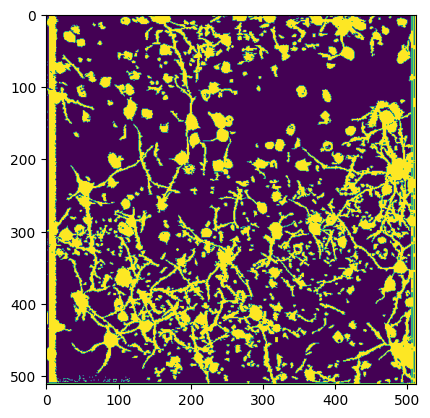

In [18]:
im = np.zeros((ops["Ly"], ops["Lx"]))
for n in range(len(roi_stats)):
    ypix = roi_stats[n]["ypix"]
    xpix = roi_stats[n]["xpix"]
    im[ypix,xpix] = 1

plt.imshow(im)

#### Segmentation from Suite2P Filtered to Cells

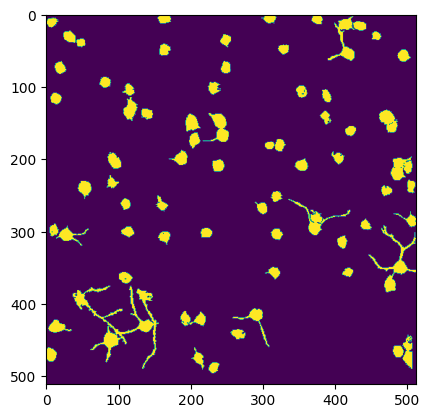

In [19]:
im = np.zeros((ops["Ly"], ops["Lx"]))
for i in range(len(roi_stats)):
    # only show if ROI is a cell according to classifier output
    if is_cell[i][0] == 1.0:
        ypix = roi_stats[i]["ypix"]
        xpix = roi_stats[i]["xpix"]
        im[ypix,xpix] = 1

plt.imshow(im)

#### Segmentation From Original NWB

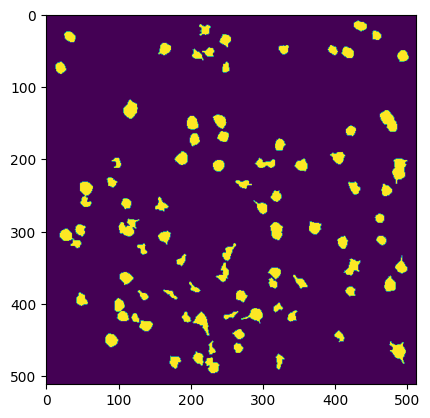

In [20]:
masks = nwb["processing/ophys/ImageSegmentation/PlaneSegmentation/image_mask"]
plt.imshow(np.logical_or.reduce(masks))